<a href="https://colab.research.google.com/github/a7lamx/Assignment/blob/main/CV_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from random import shuffle, seed
import os
import cv2
import torch


In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
train_data_dir =  '/content/drive/MyDrive/cv hw1/D&C/training_set/training_set'
test_data_dir = '/content/drive/MyDrive/cv hw1/D&C/test_set/test_set'

In [ ]:
class cats_dogs(Dataset):
    def __init__(self, folder):
        cats = glob(folder+'/cats/*.jpg')
        dogs = glob(folder+'/dogs/*.jpg')
        self.fpaths = cats + dogs
        seed(10)
        shuffle(self.fpaths)
        self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths]
    
    def __len__(self): return len(self.fpaths)
    
    def __getitem__(self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = (cv2.imread(f)[:,:,::-1])
        im = cv2.resize(im, (224,224)) #resize all the images so that they're 224 x 224 in size
        return torch.tensor(im/255).permute(2,0,1).to(device).float(), torch.tensor([target]).float().to(device)

In [ ]:
data = cats_dogs(train_data_dir)
im, label =data[300]

In [ ]:
len(data)

8058

In [ ]:
print(im.shape)

torch.Size([3, 224, 224])


tensor([1.])


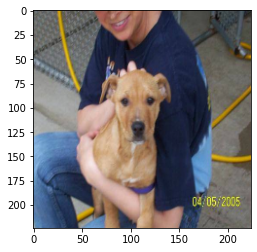

In [ ]:
plt.imshow(im.permute(1,2,0).cpu())
print(label)

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler

train_data = cats_dogs(train_data_dir)
test_data = cats_dogs(test_data_dir)

valid_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))


random_seed = 2 # for reproducibility
np.random.seed(random_seed)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(valid_idx)


batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(train_data, batch_size=batch_size, sampler=val_sampler)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [ ]:
class ConvNet1(nn.Module):
    
    
    def __init__(self):
        
        
        super().__init__()

        self.conv1=nn.Sequential(nn.Conv2d(3, 64, 3, 1,0),
                             nn.ReLU(),nn.BatchNorm2d(64), nn.MaxPool2d(2))

        self.conv2=nn.Sequential(nn.Conv2d(64, 512, 3, 1,0),
                             nn.ReLU(),nn.BatchNorm2d(512), nn.MaxPool2d(2))

        self.conv3=nn.Sequential(nn.Conv2d(512, 512, 3, 1,0),
                             nn.ReLU(),nn.BatchNorm2d(512), nn.MaxPool2d(2))

        #self.conv4=nn.Sequential(nn.Conv2d(512, 512, 3, 1,0),
                             #nn.ReLU(),nn.BatchNorm2d(512), nn.MaxPool2d(2))

        #self.conv5=nn.Sequential(nn.Conv2d(512, 512, 3, 1,0),
                             #nn.ReLU(),nn.BatchNorm2d(512), nn.MaxPool2d(2))

        #self.conv6=nn.Sequential(nn.Conv2d(512, 512, 3, 1,0),
                             #nn.ReLU(),nn.BatchNorm2d(512), nn.MaxPool2d(2))


        self.fc = nn.Linear(346112, 1).to(device)

        self.sigmoid = nn.Sigmoid()






    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        x = F.relu(self.conv3(x))

        #x = F.relu(self.conv4(x))

        #x = F.relu(self.conv5(x))

        #x = F.relu(self.conv6(x))

       #x = torch.flatten(x, 1)

        x = x.view(x.size(0), -1)

        x = self.fc(x)
        x = self.sigmoid(x)

        return x

In [ ]:
def train_batch(x, y, model, opt, loss):
    
    prediction = model(x)
    batch_loss = loss(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [ ]:
def accuracy(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [ ]:
def valid_loss(x, y, model):
    with torch.no_grad():
        prediction = model(x)
        val_loss = loss(prediction, y)
    return val_loss.item()

In [ ]:
model = ConvNet1()
loss  = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
print(model.to(device))

ConvNet1(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=346112, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
valid_losses, valid_accuracies = [], []
train_losses, train_accuracies = [], []
max_iter = 5

for epoch in range(max_iter):
    
    train_epoch_losses = []
    
    for ix, batch in enumerate(iter(train_loader)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()
    train_losses.append(train_epoch_loss)
    print(f"Epoch {epoch} ... traning loss {train_epoch_loss} ")

    
    for ix, batch in enumerate(iter(val_loader)):
        x, y = batch
        acc = accuracy(x, y, model)
    valid_losses += [valid_loss(x, y, model)]
    valid_accuracies.append(np.mean(acc))
    print(f"Epoch {epoch} ... valid accuracy {np.mean(acc)} ")
      

Epoch 0 ... traning loss 0.6794746299979113 
Epoch 0 ... valid accuracy 0.2727272727272727 
Epoch 1 ... traning loss 0.3967487528809247 
Epoch 1 ... valid accuracy 0.6363636363636364 
Epoch 2 ... traning loss 0.2522338287669139 
Epoch 2 ... valid accuracy 0.6363636363636364 
Epoch 3 ... traning loss 0.16302438682088485 
Epoch 3 ... valid accuracy 0.7272727272727273 
Epoch 4 ... traning loss 0.10230697652616216 
Epoch 4 ... valid accuracy 0.5454545454545454 


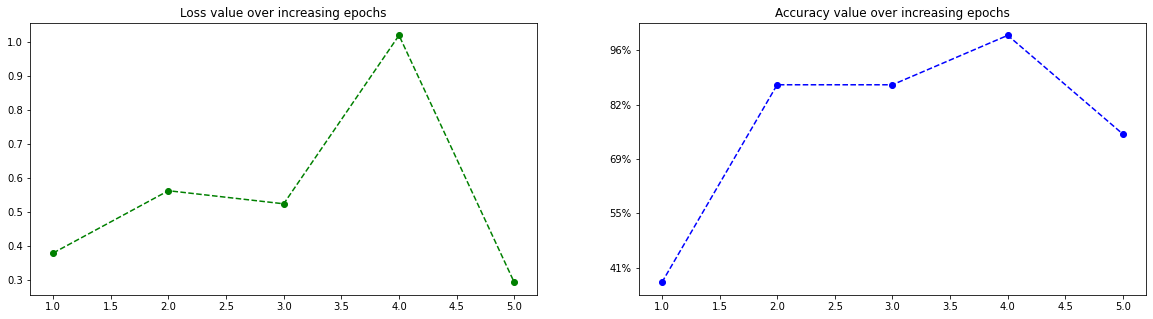

In [ ]:
import matplotlib.ticker as mtick

epochs = np.arange(5)+1
plt.figure(figsize=(20,5))

plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, valid_losses, 'go--', label='valid Loss')


ax = plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
ax.plot(epochs, valid_accuracies, 'bo--',label='valid Accuracy')

yticks = mtick.PercentFormatter(max(valid_accuracies))
ax.yaxis.set_major_formatter(yticks)

In [ ]:
for ix, batch in enumerate(iter(test_loader)):
    x, y = batch
    is_correct = accuracy(x, y, model)
    
print(f"test accuracy {np.mean(is_correct)} ")
rint(len(valid_losses))

In [ ]:
class ConvNet1(nn.Module):
    
    
    def __init__(self):
        
        
        super().__init__()

        self.conv1=nn.Sequential(nn.Conv2d(3, 64, 3, 1,0),
                             nn.ReLU(),nn.BatchNorm2d(64), nn.MaxPool2d(2))

        self.conv2=nn.Sequential(nn.Conv2d(64, 512, 3, 1,0),
                             nn.ReLU(),nn.BatchNorm2d(512), nn.MaxPool2d(2))

        self.conv3=nn.Sequential(nn.Conv2d(512, 512, 3, 1,0),
                             nn.ReLU(),nn.BatchNorm2d(512), nn.MaxPool2d(2))

        #self.conv4=nn.Sequential(nn.Conv2d(512, 512, 3, 1,0),
                             #nn.ReLU(),nn.BatchNorm2d(512), nn.MaxPool2d(2))

        #self.conv5=nn.Sequential(nn.Conv2d(512, 512, 3, 1,0),
                             #nn.ReLU(),nn.BatchNorm2d(512), nn.MaxPool2d(2))

        #self.conv6=nn.Sequential(nn.Conv2d(512, 512, 3, 1,0),
                             #nn.ReLU(),nn.BatchNorm2d(512), nn.MaxPool2d(2))


        self.fc = nn.Linear(346112, 1).to(device)

        self.sigmoid = nn.Sigmoid()






    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        x = F.relu(self.conv3(x))

        #x = F.relu(self.conv4(x))

        #x = F.relu(self.conv5(x))

        #x = F.relu(self.conv6(x))

       #x = torch.flatten(x, 1)

        x = x.view(x.size(0), -1)

        x = self.fc(x)
        x = self.sigmoid(x)

        return x

In [ ]:
def train_batch(x, y, model, opt, loss):
    
    prediction = model(x)
    batch_loss = loss(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [ ]:
def accuracy(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [ ]:
def valid_loss(x, y, model):
    with torch.no_grad():
        prediction = model(x)
        val_loss = loss(prediction, y)
    return val_loss.item()

In [ ]:
model = ConvNet1()
loss  = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
print(model.to(device))

ConvNet1(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=346112, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
valid_losses, valid_accuracies = [], []
train_losses, train_accuracies = [], []
max_iter = 4

for epoch in range(max_iter):
    
    train_epoch_losses = []
    
    for ix, batch in enumerate(iter(train_loader)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()
    train_losses.append(train_epoch_loss)
    print(f"Epoch {epoch} ... traning loss {train_epoch_loss} ")

    
    for ix, batch in enumerate(iter(val_loader)):
        x, y = batch
        acc = accuracy(x, y, model)
    valid_losses += [valid_loss(x, y, model)]
    valid_accuracies.append(np.mean(acc))
    print(f"Epoch {epoch} ... valid accuracy {np.mean(acc)} ")
      

Epoch 0 ... traning loss 49.9156240143492 
Epoch 0 ... valid accuracy 0.6363636363636364 


In [ ]:
import matplotlib.ticker as mtick

epochs = np.arange(4)+1
plt.figure(figsize=(20,5))

plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, valid_losses, 'go--', label='valid Loss')


ax = plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
ax.plot(epochs, valid_accuracies, 'bo--',label='valid Accuracy')

yticks = mtick.PercentFormatter(max(valid_accuracies))
ax.yaxis.set_major_formatter(yticks)

In [ ]:
for ix, batch in enumerate(iter(test_loader)):
    x, y = batch
    is_correct = accuracy(x, y, model)
    
print(f"test accuracy {np.mean(is_correct)} ")